In [1]:
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('whitegrid')

In [3]:
import pandas as pd

In [4]:
df_full = pd.read_csv("funshade_timings_full.csv")

In [5]:
# Select K>1
df_sel = df_full[(df_full.l!=1) & (df_full.n_samples>1)].copy() 

In [6]:
# Append 50k <= K <= 1M
import numpy as np

df_app = df_sel[df_sel.n_samples>= df_sel.n_samples.max()/5]*10
df_app[['t_setup', 't_share','t_eval_sp','t_eval_sign']] *= np.random.rand(len(df_app), 4)/200+1
df_app.l //=10
df_app.n_bits //= 10

df_app2 = df_sel[(df_sel.n_samples>= df_sel.n_samples.max()/5) & (df_sel.n_samples!= df_sel.n_samples.max())] * 100
df_app2[['t_setup', 't_share','t_eval_sp','t_eval_sign']] *= np.random.rand(len(df_app2), 4)/200+1
df_app2.l //=100
df_app2.n_bits //= 100
df_sel = df_sel.append([df_app, df_app2])

In [8]:
# Extracting t_share_x
df_single = df_full[(df_full.l!=1) & (df_full.n_samples==1)].copy()
df_single['ln_bits'] = df_single.l + df_single['n_bits']
t_share_x_dict = df_single[['ln_bits','t_share']].set_index('ln_bits')['t_share'].to_dict() 

In [9]:
# Compute comm. size (in B)
df_sel['comm_offline'] = (df_sel.n_samples*df_sel.n_bits*(2*128+9*df_sel.l+4*df_sel.n_bits+10)\
                            +2*df_sel.n_samples*128)/8
df_sel['comm_online'] = (df_sel.n_bits*(df_sel.l+2*df_sel.n_samples+2))/8

# Computation Latency
df_sel['t_offline_comp'] = df_sel.t_setup + df_sel.t_share
df_sel['t_share_x'] = (df_sel.l+df_sel.n_bits).map(t_share_x_dict)
df_sel['t_online_comp'] = df_sel.t_eval_sp + df_sel.t_eval_sign + df_sel.t_share_x

# Transmission Latency
link_speed = 100000000 # bits/seg (100Mbps)
latency_lan = 0.010 # s
latency_wan = 0.070 # s
df_sel['t_lan'] = (latency_lan*3+df_sel.comm_online/link_speed*8)
df_sel['t_wan'] = (latency_wan*3+df_sel.comm_online/link_speed*8)

# Total latency
df_sel['t_online_lan'] = (df_sel.t_online_comp/1e9) + df_sel.t_lan
df_sel['t_online_wan'] = (df_sel.t_online_comp/1e9) + df_sel.t_wan

In [10]:
df_plot = df_sel[['n_bits','l','n_samples','t_lan','t_online_lan','t_wan','t_online_wan']]\
            .rename(columns={'n_bits':'n'})

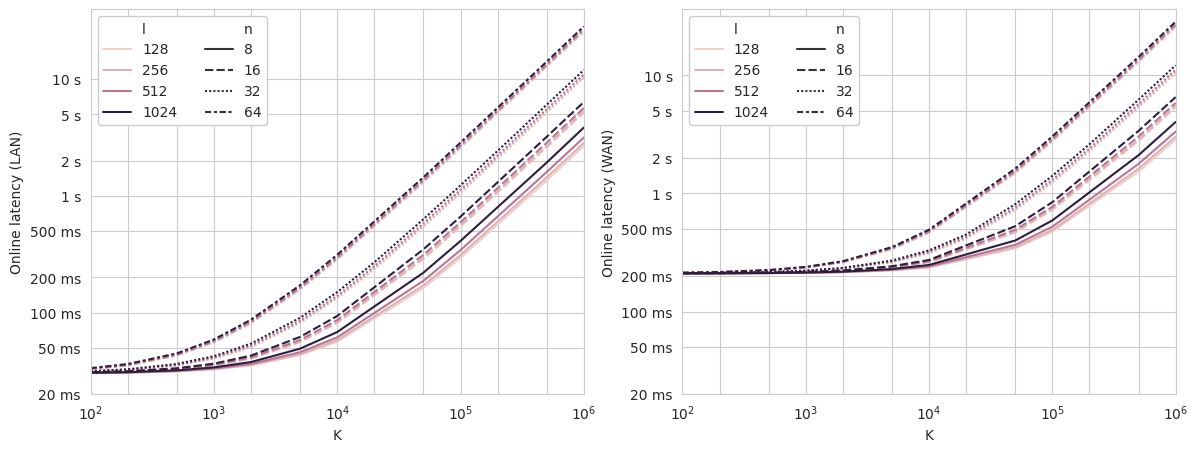

In [11]:
# Timings plot, for each value of K
fig, ax = plt.subplots(1,2, figsize=(14,5))

sns.lineplot(ax=ax[0], data=df_plot[['l','n','n_samples','t_online_lan']], x='n_samples', y='t_online_lan', hue='l', style='n')
ax[0].set(xscale="log", yscale="log",
          ylabel=("Online latency (LAN)"),
          yticks=([.02,.05, 0.1, 0.2, .5, 1, 2, 5, 10]),
          yticklabels=(['20 ms','50 ms', '100 ms', '200 ms', '500 ms','1 s', '2 s', '5 s', '10 s']),
          xticks=([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]),
          xlim = (100, 1000000),
          xlabel=("K"))
ax[0].legend(facecolor='white', ncol=2, framealpha=1)

sns.lineplot(ax=ax[1], data=df_plot[['l','n','n_samples','t_online_wan']], x='n_samples', y='t_online_wan', hue='l', style='n')
ax[1].set(xscale="log", yscale="log",
          ylabel=("Online latency (WAN)"),
          yticks=([.02,.05, 0.1, 0.2, .5, 1, 2, 5, 10]),
          yticklabels=(['20 ms','50 ms', '100 ms', '200 ms', '500 ms','1 s', '2 s', '5 s', '10 s']),
          xticks=([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]),
          xlim = (100, 1000000),
          xlabel=("K"))
ax[1].legend(facecolor='white', ncol=2, framealpha=1)

In [305]:
fig.savefig("funshade_plot_latency.pdf", dpi=300, transparent=False)

In [12]:
df_plot['comm_lat_ratio_lan'] = df_plot.t_lan / df_plot.t_online_lan
df_plot['comm_lat_ratio_wan'] = df_plot.t_wan / df_plot.t_online_wan

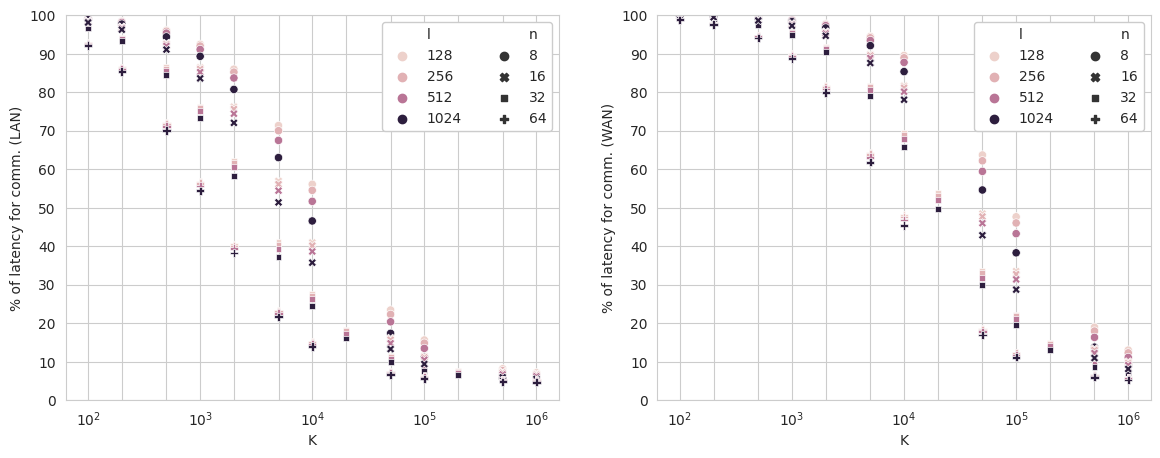

In [13]:
# % of latency for comm., based on K
fig2, ax2 = plt.subplots(1,2, figsize=(14,5))
sns.scatterplot(ax=ax2[0], data=df_plot, x='n_samples', y='comm_lat_ratio_lan', hue='l', style='n')
ax2[0].set(
    xscale="log",
    ylabel="% of latency for comm. (LAN)",
    ylim=(0,1),
    yticks=([t/100 for t in range(0,101,10)]),
    yticklabels=([str(t) for t in range(0,101,10)]),
    xticks=([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]),
    xlabel=("K"))
ax2[0].legend(facecolor='white', ncol=2, framealpha=1)

sns.scatterplot(ax=ax2[1], data=df_plot, x='n_samples', y='comm_lat_ratio_wan', hue='l', style='n')
ax2[1].set(
    xscale="log",
    ylabel="% of latency for comm. (WAN)",
    ylim=(0,1),
    yticks=([t/100 for t in range(0,101,10)]),
    yticklabels=([str(t) for t in range(0,101,10)]),
    xticks=([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]),
    xlabel=("K"))
ax2[1].legend(facecolor='white', ncol=2, framealpha=1)

In [14]:
fig2.savefig("funshade_plot_comm_ratio.pdf", dpi=300, transparent=False)